### In this notebook, I have used 'Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A' which collected CO2 samples from March 1958 to December 2001. The dataset consists of date and co2 samples for every week from 1958 to 2001 year. Analysed the dataset for trend, seasonality, noise using various statistical functions. Applied SARIMA and LSTM model to dataset because time series has seasonal component and forecasts co2 samples for next 30 years.

Some of the tools and techniques used in this notebook, I have referenced the following websites.

https://www.digitalocean.com/community/tutorials/

https://machinelearningmastery.com/

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas import concat
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from multiprocessing import cpu_count
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.rcParams["figure.figsize"] = [9,7]
import itertools
import warnings
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional

Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


### 1. General information about dataset

In [2]:
co2_data = sm.datasets.co2.load_pandas()

In [3]:
co2 = co2_data.data

In [4]:
co2.index.name = 'Date'
co2

,co2
Date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2


In [5]:
def general_info(data):
    print(data.head(10),'\n')
    print(data.info(), '\n')
    print(data.describe(), '\n')
    print(data.index, '\n')
    print('Missing values:',data.isnull().sum())

In [6]:
general_info(co2)

              co2
Date             
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4
1958-05-03  316.9
1958-05-10    NaN
1958-05-17  317.5
1958-05-24  317.9
1958-05-31    NaN 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB
None 

               co2
count  2225.000000
mean    340.142247
std      17.003885
min     313.000000
25%     324.800000
50%     338.300000
75%     354.800000
max     373.900000 

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-0

In [7]:
co2_new = co2['co2'].resample('MS').mean()
co2_data = pd.DataFrame(co2_new)

In [8]:
general_info(co2_data)

                   co2
Date                  
1958-03-01  316.100000
1958-04-01  317.200000
1958-05-01  317.433333
1958-06-01         NaN
1958-07-01  315.625000
1958-08-01  314.950000
1958-09-01  313.500000
1958-10-01         NaN
1958-11-01  313.425000
1958-12-01  314.700000 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 526 entries, 1958-03-01 to 2001-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     521 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB
None 

              co2
count  521.000000
mean   339.822665
std     17.068711
min    313.400000
25%    324.125000
50%    337.950000
75%    354.675000
max    373.800000 

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-0

In [9]:
co2_data = co2_data.fillna(co2_data.bfill())

In [10]:
general_info(co2_data)

                   co2
Date                  
1958-03-01  316.100000
1958-04-01  317.200000
1958-05-01  317.433333
1958-06-01  315.625000
1958-07-01  315.625000
1958-08-01  314.950000
1958-09-01  313.500000
1958-10-01  313.425000
1958-11-01  313.425000
1958-12-01  314.700000 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 526 entries, 1958-03-01 to 2001-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     526 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB
None 

              co2
count  526.000000
mean   339.624826
std     17.110954
min    313.400000
25%    324.025000
50%    337.912500
75%    354.537500
max    373.800000 

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-0

In [11]:
co2_data.shape

(526, 1)

### 2. Lag Features

#### Consider the last 1 observed value(lag value) to predcit the value at the next time step. This is the format of dataset expected by any machine learning algorithms.

In [61]:
co2data_onelag = concat([co2_data.shift(1), co2_data], axis=1)
co2data_onelag.columns = ['t-1', 't+1']
co2data_onelag.head(5)

,t-1,t+1
1958-03-01,NaN,316.100000
1958-04-01,316.100000,317.200000
1958-05-01,317.200000,317.433333
1958-06-01,317.433333,315.625000
1958-07-01,315.625000,315.625000


#### Similarly consider the last 2 observed values(lag values) to predict the value at the next time step. This is the format of dataset expected by any machine learning algorithms ie [(t-2), (t-1)] is an input and t+1 in an output.

In [62]:
co2data_two_lag = concat([co2_data.shift(2), co2_data.shift(1), co2_data], axis = 1)
co2data_two_lag.columns = ['t-2', 't-1', 't+1']
co2data_two_lag.head(10)

,t-2,t-1,t+1
1958-03-01,NaN,NaN,316.100000
1958-04-01,NaN,316.100000,317.200000
1958-05-01,316.100000,317.200000,317.433333
1958-06-01,317.200000,317.433333,315.625000
1958-07-01,317.433333,315.625000,315.625000
1958-08-01,315.625000,315.625000,314.950000
1958-09-01,315.625000,314.950000,313.500000
1958-10-01,314.950000,313.500000,313.425000
1958-11-01,313.500000,313.425000,313.425000
1958-12-01,313.425000,313.425000,314.700000


#### Rolling Window - instead of just adding the raw lagged values is to add a summary (mean, sum, etc) across the values in the window of size 2 at previous time steps.

In [63]:
co2data_shifted = co2_data.shift(1)
window_mean = co2data_shifted.rolling(window = 2).mean()
co2data_window_mean = concat([window_mean, co2_data], axis=1)
co2data_window_mean.columns = ['mean(t-2, t-1)', 't+1']
co2data_window_mean.head(10)

,"mean(t-2, t-1)",t+1
1958-03-01,NaN,316.100000
1958-04-01,NaN,317.200000
1958-05-01,316.650000,317.433333
1958-06-01,317.316667,315.625000
1958-07-01,316.529167,315.625000
1958-08-01,315.625000,314.950000
1958-09-01,315.287500,313.500000
1958-10-01,314.225000,313.425000
1958-11-01,313.462500,313.425000
1958-12-01,313.425000,314.700000


#### Below code shows a window width of 3 and a dataset comprised of more summary statistics, specifically the minimum, mean, and maximum value in the window.

In [64]:
width = 3
shifted = co2_data.shift(width-1)
window = shifted.rolling(window = width)
co2data_window_3 = concat([window.min(), window.mean(), window.max(), co2_data], axis=1)
co2data_window_3.columns = ['min', 'mean', 'max', 't+1']
co2data_window_3.head(10)

,min,mean,max,t+1
1958-03-01,NaN,NaN,NaN,316.100000
1958-04-01,NaN,NaN,NaN,317.200000
1958-05-01,NaN,NaN,NaN,317.433333
1958-06-01,NaN,NaN,NaN,315.625000
1958-07-01,316.100,316.911111,317.433333,315.625000
1958-08-01,315.625,316.752778,317.433333,314.950000
1958-09-01,315.625,316.227778,317.433333,313.500000
1958-10-01,314.950,315.400000,315.625000,313.425000
1958-11-01,313.500,314.691667,315.625000,313.425000
1958-12-01,313.425,313.958333,314.950000,314.700000


### Expanding Window

In [66]:
window = co2_data.expanding()
co2window_exp = concat([window.min(), window.mean(), window.max(), co2_data.shift(1)], axis=1)
co2window_exp.columns = ['min', 'mean', 'max', 't+1']
co2window_exp.head(10)

,min,mean,max,t+1
1958-03-01,316.100,316.100000,316.100000,NaN
1958-04-01,316.100,316.650000,317.200000,316.100000
1958-05-01,316.100,316.911111,317.433333,317.200000
1958-06-01,315.625,316.589583,317.433333,317.433333
1958-07-01,315.625,316.396667,317.433333,315.625000
1958-08-01,314.950,316.155556,317.433333,315.625000
1958-09-01,313.500,315.776190,317.433333,314.950000
1958-10-01,313.425,315.482292,317.433333,313.500000
1958-11-01,313.425,315.253704,317.433333,313.425000
1958-12-01,313.425,315.198333,317.433333,313.425000


### 3. Check for stationarity

#### The below line plot shows that the given time series has obvious increasing trend and seasonal component

Text(0, 0.5, 'co2 level')

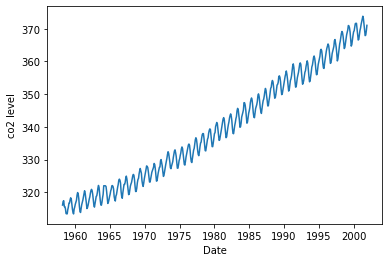

In [67]:
plt.plot(co2_data)
plt.xlabel('Date')
plt.ylabel('co2 level')

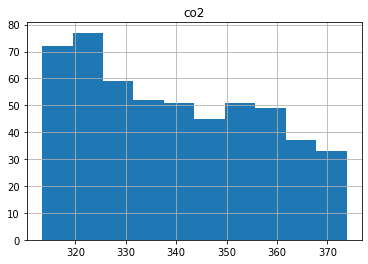

In [68]:
co2_data.hist()
plt.show()

#### Histogram shows that the time series is not uniformly distributed. So the time series is non-stationary

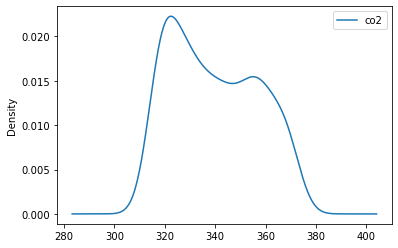

In [69]:
co2_data.plot(kind = 'kde')
plt.show()

#### Another way to check for stationarity is to consider the mean and variance of the two groups of dataset. If mean and variance of these groups vary much then this suggests that the given time series is non-stationary.

In [73]:
def split_data(data):
    split = round(len(co2_data) / 2)
    x1, x2 = co2_data[0:split], co2_data[split:]
    mean1, mean2 = x1.mean(), x2.mean()
    variance1, variance2 = x1.var(), x2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (variance1, variance2))

In [74]:
split_data(co2_data)

mean1=324.781153, mean2=354.468498
variance1=45.400536, variance2=98.935277


### Augmented Dickey - Fuller Test
The ADF statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary). 
Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that 
the time series is non-stationary and does have time-dependent structure. Another observation is p-value > 0.05, the data is
non-stationary

In [78]:
def perform_adf(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [79]:
perform_adf(co2_data)

ADF Statistic: 2.359810
p-value: 0.998990
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [80]:
def check(data):
    moving_average=data.rolling(window=12).mean()
    moving_std=data.rolling(window=12).std()
    plt.plot(data, color = 'green', label = 'Original')
    plt.plot(moving_average, color='red', label = 'Moving Average ')
    plt.plot(moving_std, color='black', label = 'Moving std')
    plt.title('Rolling Mean and Std')
    plt.legend(loc='best')
    plt.show()

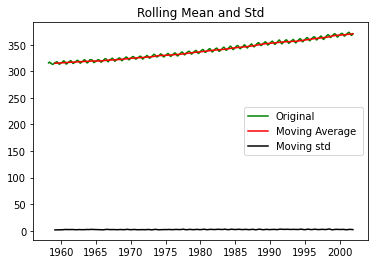

In [81]:
check(co2_data)

### 4. Time Series Decomposition

In [83]:
def decomposition_additive(data):
    results = seasonal_decompose(data, model='additive')
    results.plot()
    plt.show()

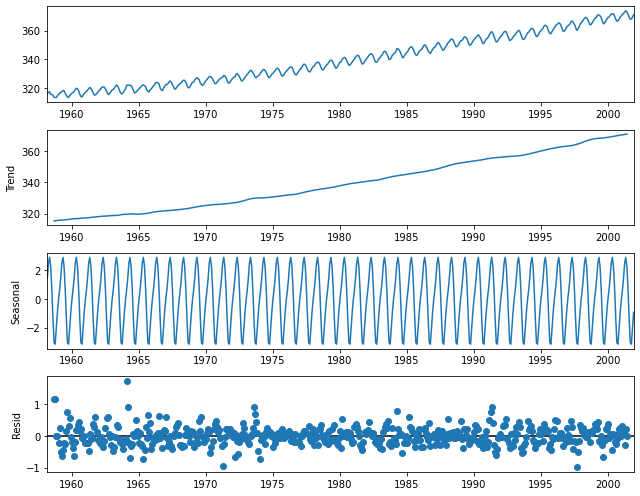

In [86]:
decomposition_additive(co2_data)

In [88]:
def decomposition_multiplicative(data):
    results = seasonal_decompose(data, model='multiplicative')
    results.plot()
    plt.show()

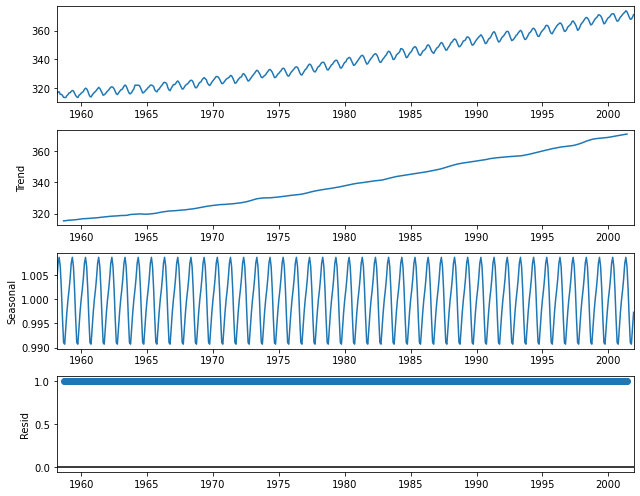

In [89]:
decomposition_multiplicative(co2_data)

### AutoCorrelation using lag_plot()

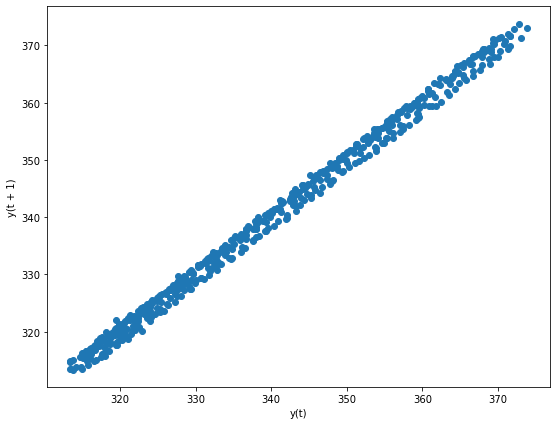

In [90]:
lag_plot(co2_data)
plt.show()

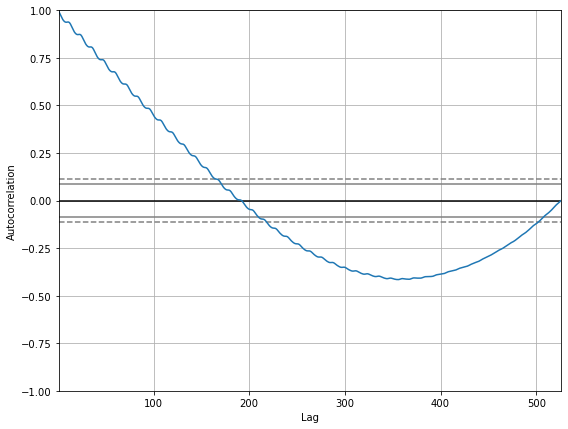

In [91]:
autocorrelation_plot(co2_data)
plt.show()

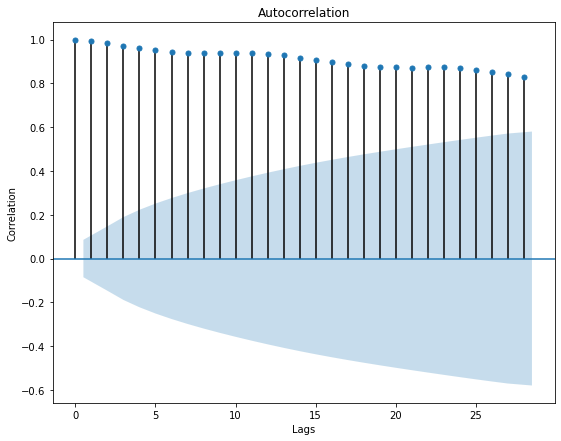

In [92]:
plot_acf(co2_data)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

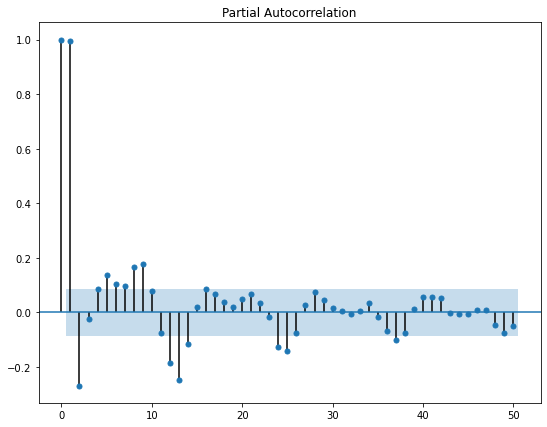

In [93]:
plot_pacf(co2_data, lags=50)
plt.show()

#### Differencing using diff() function to remove trends and seasonality in the time series.

Text(0.5, 1.0, 'first order differencing')

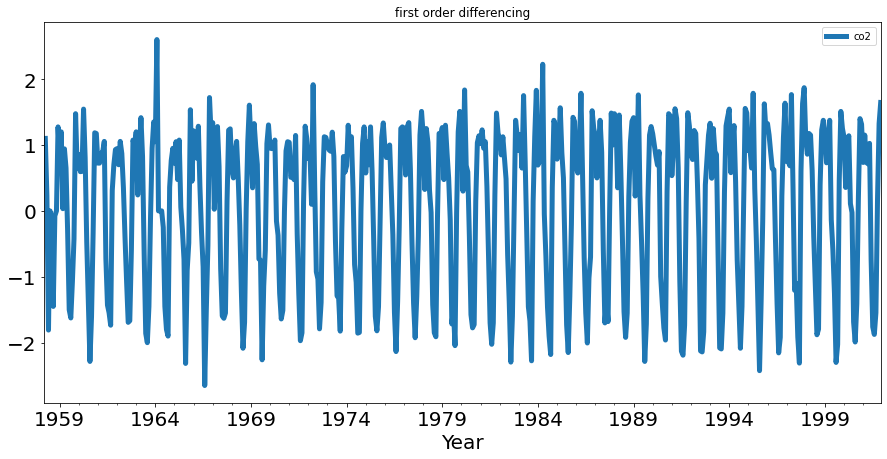

In [96]:
co2_data.diff().plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("first order differencing")

Text(0.5, 1.0, 'Second order differencing')

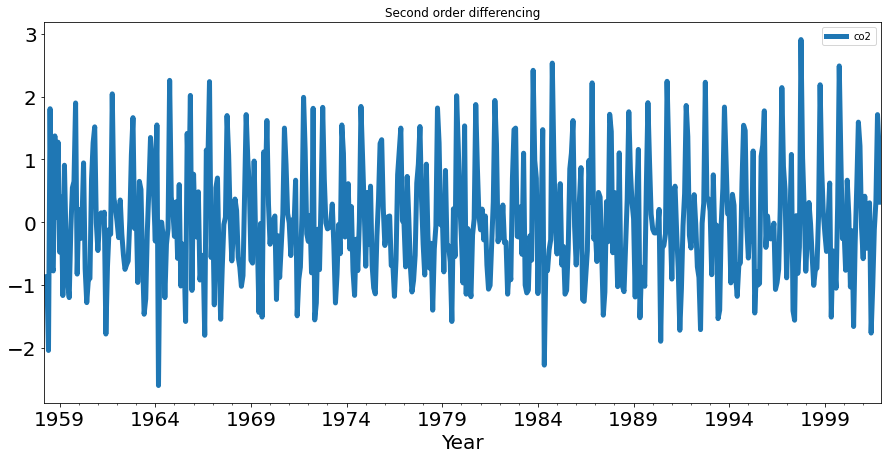

In [95]:
co2_data.diff().diff().plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("Second order differencing")

#### Seasonal difference

Text(0.5, 1.0, 'Seasonal differencing')

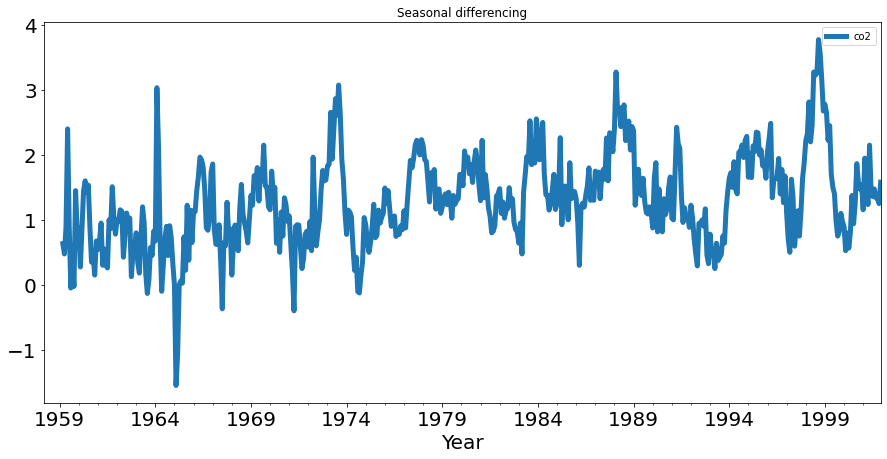

In [97]:
co2_data.diff(12).plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("Seasonal differencing")

### 5. Since the given time series has a seasonal component, use SARIMA model. Since this model has three parameters for non-seasonal component and four parameters for seasonal component, its better to get the good parameters using grid search.

In [100]:
# Define p, d, q parameters between 0 and 3
p = d = q = range(0,3)
# Generate different combinations of p, d, q
pdq = list(itertools.product(p, d, q))
# Generate different combinations of p, d, q for seasonal component
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [103]:
warnings.filterwarnings("ignore")
for param in pdq:
    for params in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(co2_data, 
                                            order = param,
                                            sesonal_order = params,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, params, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:7612.583429881011
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:7612.583429

#### we found from grid search that (2, 1, 2) for non-seasonal and (2, 0, 2, 12) for seasonal component based on AIC metric. Lets fit the model with these parameters.

In [119]:
mod = sm.tsa.statespace.SARIMAX(co2_data,
                               order = (2, 1, 2),
                               seasonal_order = (2, 0, 2, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -130.394
Date:                            Sun, 19 Jul 2020   AIC                            278.787
Time:                                    16:34:45   BIC                            316.683
Sample:                                03-01-1958   HQIC                           293.660
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9951      0.287      3.465      0.001       0.432       1.558
ar.L2         -0.2538      0.128   

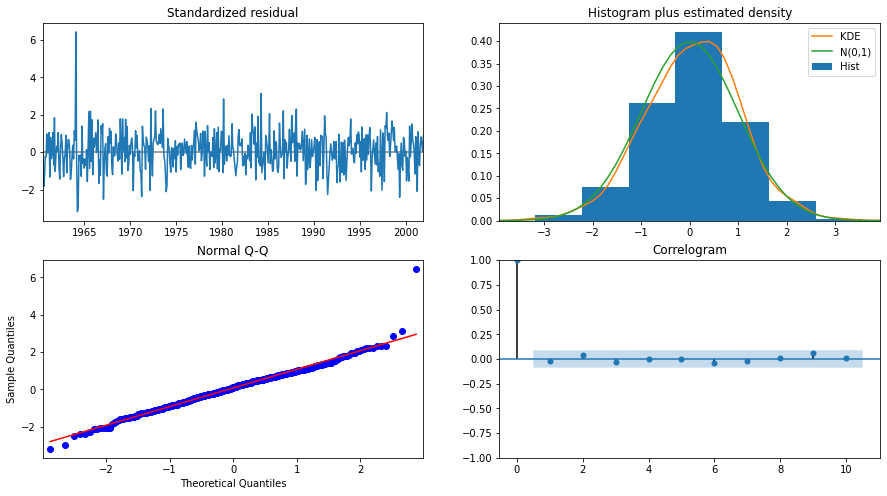

In [120]:
results.plot_diagnostics(figsize = (15, 8))
plt.show()

### 6. Validating forecasts: forecast to start at 1980-01-01, dynamic = False

In [122]:
pred = results.get_prediction(start = pd.to_datetime('1980-01-01'), dynamic = False)
pred_ci = pred.conf_int()

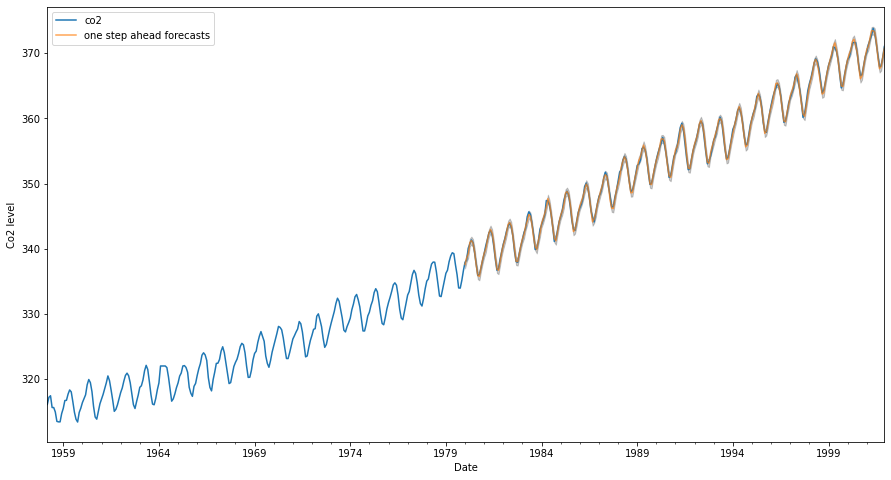

In [132]:
ax = co2_data['1958-03-01':].plot(label='observed', figsize = (15, 8))
pred.predicted_mean.plot(ax=ax, label = 'one step ahead forecasts', alpha = .7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('Co2 level')
plt.legend()
plt.show()

In [130]:
co2_data

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000
...,...
2001-08-01,369.425000
2001-09-01,367.880000
2001-10-01,368.050000
2001-11-01,369.375000


In [134]:
co2data_forecast = pred.predicted_mean
co2data_actual = co2_data['1980-01-01':]
mae = mean_absolute_error(co2data_actual, co2data_forecast)
mse = mean_squared_error(co2data_actual, co2data_forecast)
rmse = sqrt(mse)
print('Mean Absoulte Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absoulte Error: 0.23706728833959329
Mean Squared Error: 0.08645829725081323
Root Mean Squared Error: 0.29403791804937884


### 7. Validating forecasts: forecast to start at 1980-01-01, dynamic = True

In [135]:
pred_dynamic = results.get_prediction(start = pd.to_datetime('1980-01-01'), dynamic = True, full_results = True)
pred_dynamic_ci = pred_dynamic.conf_int()

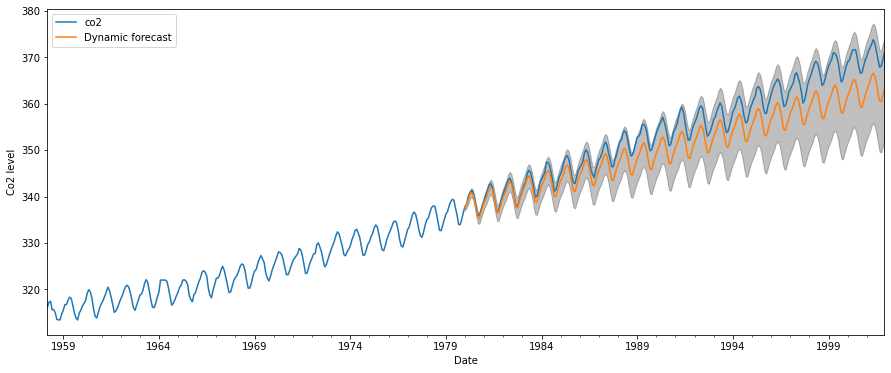

In [136]:
ax1 = co2_data['1958-03-01':].plot(label='observed', figsize = (15, 6))
pred_dynamic.predicted_mean.plot(ax=ax1, label = 'Dynamic forecast')

ax1.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .25)
ax1.set_xlabel('Date')
ax1.set_ylabel('Co2 level')
plt.legend()
plt.show()

In [137]:
co2data_forecast_dynamic = pred_dynamic.predicted_mean
co2data_actual = co2_data['1980-01-01':]
mae_dynamic = mean_absolute_error(co2data_actual, co2data_forecast_dynamic)
mse_dynamic = mean_squared_error(co2data_actual, co2data_forecast_dynamic)
rmse_dynamic = sqrt(mse_dynamic)
print('Mean Absoulte Error:', mae_dynamic)
print('Mean Squared Error:', mse_dynamic)
print('Root Mean Squared Error:', rmse_dynamic)

Mean Absoulte Error: 3.7271784993936445
Mean Squared Error: 18.64754421513143
Root Mean Squared Error: 4.318280238142428


### Forecast future values for next 30 years

In [138]:
# Get forecast 30 steps ahead in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


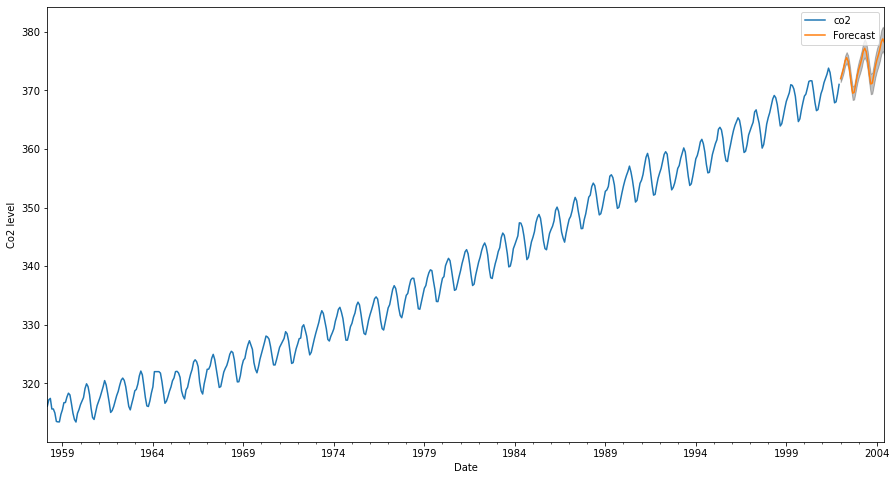

In [139]:
ax3 = co2_data.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax3, label='Forecast')
ax3.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax3.set_xlabel('Date')
ax3.set_ylabel('Co2 level')

plt.legend()
plt.show()

In [140]:
results.forecast(30)

2002-01-01    372.006319
2002-02-01    372.830704
2002-03-01    373.788875
2002-04-01    375.042977
2002-05-01    375.594678
2002-06-01    374.982400
2002-07-01    373.392779
2002-08-01    371.294949
2002-09-01    369.519964
2002-10-01    369.661978
2002-11-01    371.041607
2002-12-01    372.476407
2003-01-01    373.565610
2003-02-01    374.401202
2003-03-01    375.382924
2003-04-01    376.667413
2003-05-01    377.192416
2003-06-01    376.588428
2003-07-01    374.997975
2003-08-01    372.881242
2003-09-01    371.091421
2003-10-01    371.232091
2003-11-01    372.619654
2003-12-01    374.048622
2004-01-01    375.143574
2004-02-01    375.987359
2004-03-01    376.971376
2004-04-01    378.256944
2004-05-01    378.788553
2004-06-01    378.179833
Freq: MS, dtype: float64

### LSTM

### Scaling the data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(co2_data)

In [14]:
# split into train and test sets
train_size = int(len(scaled_data)*0.75)
test_size = len(scaled_data) - train_size
train_data,test_data=scaled_data[0:train_size,:],scaled_data[train_size:len(scaled_data),:]
print(len(train_data), len(test_data))

394 132


In [17]:
# converting an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    x, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] 
        x.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(x), np.array(y)

In [18]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [19]:
trainX.shape

(392, 1)

In [20]:
trainY.shape

(392,)

In [21]:
testX.shape

(130, 1)

In [22]:
testY.shape

(130,)

In [23]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [24]:
trainX.shape

(392, 1, 1)

In [25]:
testX.shape

(130, 1, 1)

In [26]:
model1 = Sequential()
model1.add(LSTM(50, input_shape=(1, look_back)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0226
Epoch 2/100
 - 1s - loss: 0.0016
Epoch 3/100
 - 1s - loss: 4.1731e-04
Epoch 4/100
 - 1s - loss: 4.5350e-04
Epoch 5/100
 - 1s - loss: 4.4821e-04
Epoch 6/100
 - 1s - loss: 4.5197e-04
Epoch 7/100
 - 1s - loss: 4.3674e-04
Epoch 8/100
 - 1s - loss: 4.5961e-04
Epoch 9/100
 - 1s - loss: 4.2610e-04
Epoch 10/100
 - 1s - loss: 4.6835e-04
Epoch 11/100
 - 1s - loss: 4.3525e-04
Epoch 12/100
 - 1s - loss: 4.4427e-04
Epoch 13/100
 - 1s - loss: 4.2995e-04
Epoch 14/100
 - 1s - loss: 4.3515e-04
Epoch 15/100
 - 1s - loss: 4.2857e-04
Epoch 16/100
 - 1s - loss: 4.2844e-04
Epoch 17/100
 - 1s - loss: 4.6247e-04
Epoch 18/100
 - 1s - loss: 4.4155e-04
Epoch 19/100
 - 1s - loss: 4.5988e-04
Epoch 20/100
 - 1s - loss: 4.5278e-04
Epoch 21/100
 - 1s - loss: 4.7086e-04
Epoch 22/100
 - 1s - loss: 4.5094e-04
Epoch 23/100
 - 1s - loss: 4.2310e-04
Epoch 24/100
 - 1s - loss: 4.4269e-04
Epoch 25/100
 - 1s - loss: 4.3031e-04
Epoch 26/100
 - 1s - loss: 4.6961e-04
Epoch 27/100
 - 1s - loss: 4.

In [27]:
# make predictions
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.59 RMSE
Test Score: 1.94 RMSE


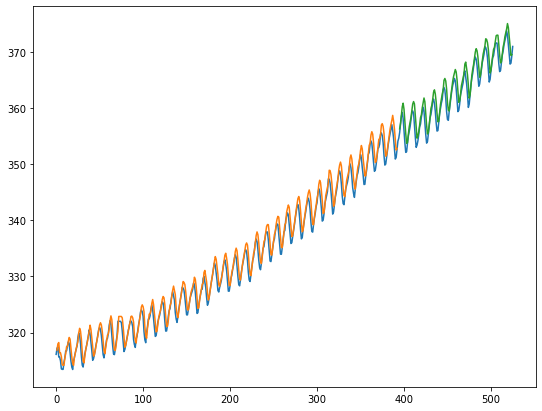

In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()